In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import numpy as np
import xgboost, numpy, textblob, string

C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\PIL\Image.py:82: RuntimeWarning: The _imaging extension was built for another version of Pillow or PIL:
Core version: 5.3.0
Pillow version: 5.1.0
  warnings.warn(str(v), RuntimeWarning)


## Read data

In [4]:
data_en = pd.read_csv("data/dataset_en_processed.csv")
data_nl = pd.read_csv("data/dataset_nl_processed.csv") 

In [5]:
data = data_en.append(data_nl, ignore_index=True)

In [6]:
len(data)

861

### Filter unknown

In [7]:
data = data[data.cluster != "unknown"]

In [157]:
data = data[data.cluster != "food "]

### Filter inadequate data

In [8]:
def inadequate_data(content):
    if len(str(content).split(" ")) > 20:
        return content
    else:
        return "None"

In [9]:
data["content"] = data["content"].apply(inadequate_data)

In [10]:
data = data[data.content != "None"]

In [11]:
data['index1'] = data.index

In [12]:
len(data)

801

## Split into train & test

In [13]:
train_x_idx, valid_x_idx, train_y, valid_y = model_selection.train_test_split(data['index1'], data['cluster'])

In [14]:
train_x = data.content[train_x_idx]
valid_x = data.content[valid_x_idx]

### Create count vectorizer

In [15]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(data['content'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

### Get tfidf & ngrams

In [16]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(data['content'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2), max_features=5000)
tfidf_vect_ngram.fit(data['content'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

### train function

In [17]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    print(metrics.accuracy_score(predictions, valid_y))
    return predictions


In [18]:
# Linear Classifier on Ngram Level TF IDF Vectors
predictions = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)


C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7114427860696517


In [107]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)

C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.595


In [114]:
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)

0.615


C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [115]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
#print ("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
#print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
#print("NB, N-Gram Vectors: ", accuracy)


0.64
0.59
0.565


In [116]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
#print("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
#print("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
#print("LR, N-Gram Vectors: ", accuracy)



C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.715
0.685
0.66


In [84]:
# RF on Count Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
#print("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
#print("RF, WordLevel TF-IDF: ", accuracy)

C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.58
0.645


C:\Users\b.eskili\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [85]:
# Extereme Gradient Boosting on Count Vectors
prediction = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
#print("Xgb, Count Vectors: ", accuracy)


0.665


In [118]:
# Extereme Gradient Boosting on Word Level TF IDF Vectors
prediction = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
#print("Xgb, WordLevel TF-IDF: ", accuracy)

0.685


In [19]:
# Extereme Gradient Boosting on ngram Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram.tocsc(), train_y, xvalid_tfidf_ngram.tocsc())
#print("Xgb, CharLevel Vectors: ", accuracy)

0.6666666666666666


In [20]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(valid_y, predictions)

In [21]:
class_names = list(set(data.cluster))

Confusion matrix, without normalization


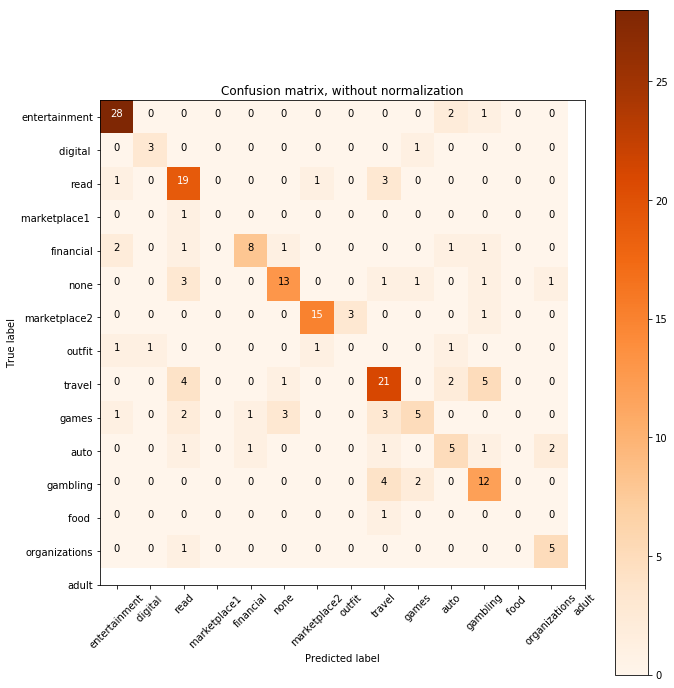

In [23]:
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')



    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(valid_y, accuracy)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

plt.figure()
plt.figure(figsize = (10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

In [38]:
i = 0
for idx in valid_x_idx:
    if data.cluster[idx] != accuracy[i]:
        print(data.website[idx])
        print("True: ", data.cluster[idx])
        print("Predicted: ", accuracy[i])
    i = i+1

http://www.coralorder.com
True:  food 
Predicted:  digital 
http://www.zumba.com
True:  travel
Predicted:  marketplace1 
http://breakoutgaming.com
True:  gambling
Predicted:  games
http://www.beautifulagony.com
True:  adult
Predicted:  outfit
http://www.prestop.nl
True:  digital 
Predicted:  marketplace1 
http://www.LockTrust.com
True:  food 
Predicted:  digital 
http://www.iapp.org
True:  organizations
Predicted:  digital 
http://bioactiveplus.com
True:  food 
Predicted:  marketplace2
http://WWW.RAININTL.COM
True:  marketplace2
Predicted:  food 
http://www.ikwinkelgezond.be
True:  food 
Predicted:  marketplace1 
http://js-trend.com
True:  organizations
Predicted:  digital 
http://www.loserpool.com
True:  gambling
Predicted:  games
http://www.24win.com
True:  gambling
Predicted:  outfit
http://www.rebelcactus.com
True:  outfit
Predicted:  games
http://www.alua.com
True:  adult
Predicted:  organizations
http://www.join.gop
True:  organizations
Predicted:  digital 
http://www.hmv.com.hk


In [86]:
sample = data[data.cluster == "gambling"]

In [87]:
len(sample)

78

In [96]:
web = data[data.website == "http://www.rebelcactus.com"]

In [97]:
web.content[int(web.index1)]

'home shop news contact nederlands english deutsch creative bell watch explore world without parent explore world rebel cactus call play music game sleeves accessories order rebel cactus choose different sleeves call watch nobody thing think suit best choose combine change rebel cactus call watch swipe black view download rebel cactus game download directly view angry bird tic tac toe candy crush view order go shop en work days order next day house free delivery postnl belgium work days order next day deliver belgium secure online payment ideal mastercard mr cash paypal visa card question call us anyway way rebel cactus bell watch tree climbers telaatkomers dog walkers sidewalk football players pee tamper da gdromers make rebel cactus really fit rebel cactus always music make awesome picture movies rebel cactus also always call parent phone would go away okay find world course see rebel cactus time also text shoot video make music play music course call rebel cactus go world without pa